In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import cv2
from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
import os
print(os.listdir("../input/fer2013/train"))

['fear', 'surprise', 'neutral', 'happy', 'angry', 'disgust', 'sad']


In [3]:
labels = []
for i in os.listdir('../input/fer2013/train/fear'):
    labels.append(0)
for i in os.listdir('../input/fer2013/train/happy'):
    labels.append(1)
for i in os.listdir('../input/fer2013/train/sad'):
    labels.append(2)
for i in os.listdir('../input/fer2013/train/neutral'):
    labels.append(3)
for i in os.listdir('../input/fer2013/train/surprise'):
    labels.append(4)
for i in os.listdir('../input/fer2013/train/angry'):
    labels.append(5)
for i in os.listdir('../input/fer2013/train/disgust'):
    labels.append(6)

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0
    for expression in os.listdir("../input/fer2013/train"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("../input/fer2013/train/" + expression + "/" +os.listdir("../input/fer2013/train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")
            plt.title(expression)

    plt.tight_layout()
    return plt


In [7]:
from tensorflow.keras.preprocessing.image import  load_img, img_to_array

In [8]:
import matplotlib.pyplot as plt

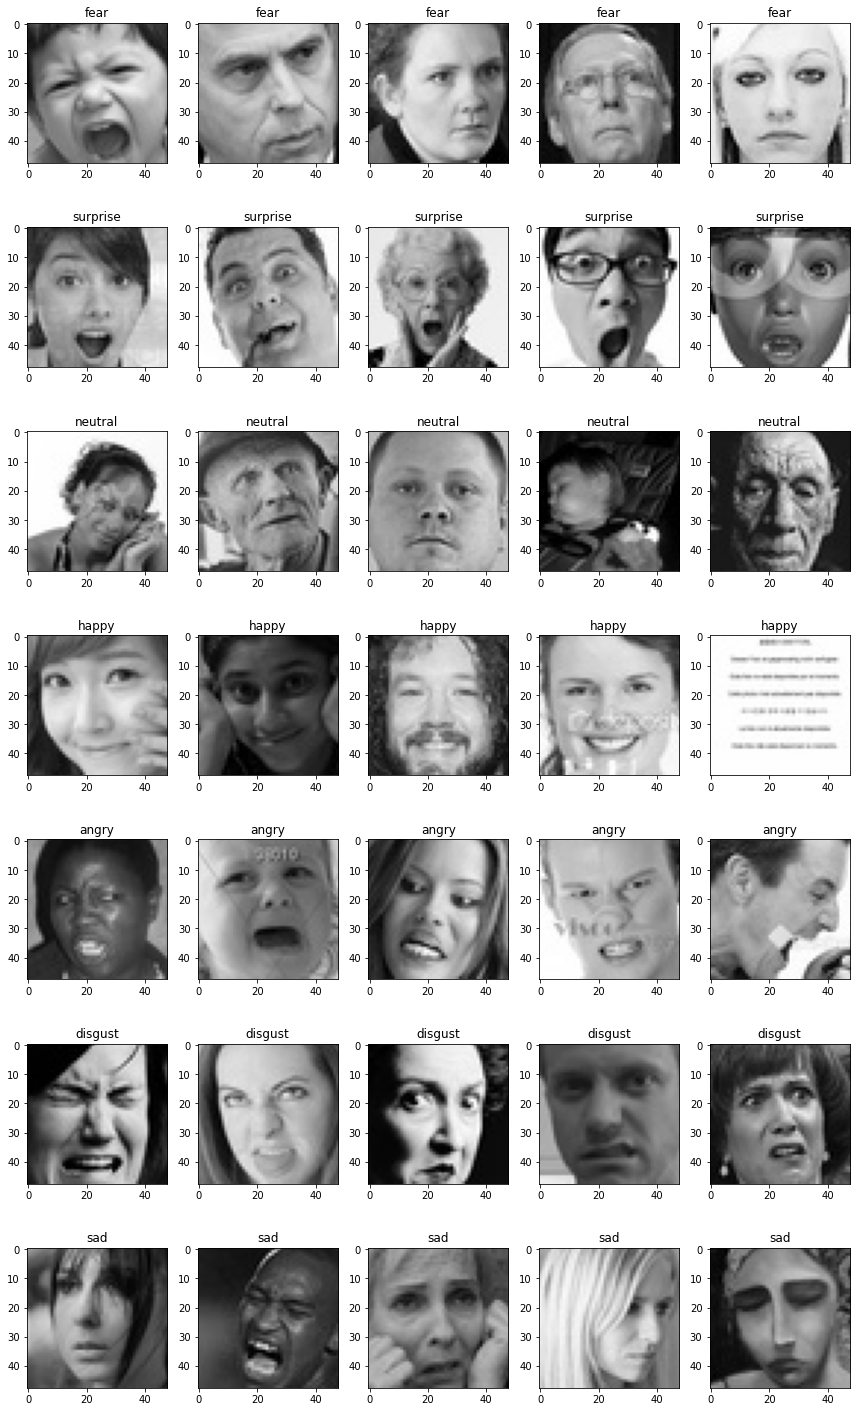

In [9]:
plot_example_images(plt).show()

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [11]:
pre_trained_model = InceptionV3(input_shape = (250,188,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [12]:
for layer in pre_trained_model.layers:
    layer.trainable = False
 
for layer in pre_trained_model.layers[140:]:
    layer.trainable = True
    
    

In [13]:
from keras import layers
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

In [14]:
seed = 100
np.random.seed(seed=seed)

In [15]:
    x = pre_trained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(7, activation='softmax', name='predictions')(x)

In [16]:
model = Model(pre_trained_model.input, predictions)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 188, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 93, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 93, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 93, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      horizontal_flip=True)
train_generator = train_datagen.flow_from_directory("../input/fer2013/train", target_size = (250,188),
                                             color_mode = 'rgb',
                                             batch_size = 64,
                                             class_mode = 'categorical',
                                             shuffle = True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory("../input/fer2013/test", target_size = (250,188),
                                             color_mode = 'rgb',
                                             batch_size = 64,
                                             class_mode = 'categorical',
                                             shuffle = True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size


In [20]:
import keras

In [21]:
checkpoint = keras.callbacks.ModelCheckpoint("os./model_weights.h5", monitor='val_accuracy',
                            save_weights_only = True, 
                            mode = 'max',
                            verbose = 1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [22]:
callbacks = [checkpoint, lr_reducer, checkpointer]

In [23]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
                    validation_data=test_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)


Epoch 1/30
448/448 [==============================] - ETA: 0s - loss: 1.5107 - accuracy: 0.4149
Epoch 00001: saving model to os./model_weights.h5

Epoch 00001: val_loss improved from inf to 2.02182, saving model to model.h5
448/448 [==============================] - 435s 970ms/step - loss: 1.5107 - accuracy: 0.4149 - val_loss: 2.0218 - val_accuracy: 0.4513
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 1.2003 - accuracy: 0.5502
Epoch 00002: saving model to os./model_weights.h5

Epoch 00002: val_loss improved from 2.02182 to 1.12340, saving model to model.h5
448/448 [==============================] - 367s 819ms/step - loss: 1.2003 - accuracy: 0.5502 - val_loss: 1.1234 - val_accuracy: 0.5864
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 1.1284 - accuracy: 0.5815
Epoch 00003: saving model to os./model_weights.h5

Epoch 00003: val_loss did not improve from 1.12340
448/448 [==============================] - 369s 825ms/step - loss: 1.1284 - accu

Epoch 24/30
448/448 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.7422
Epoch 00024: saving model to os./model_weights.h5

Epoch 00024: val_loss did not improve from 0.90950
448/448 [==============================] - 347s 775ms/step - loss: 0.6969 - accuracy: 0.7422 - val_loss: 0.9183 - val_accuracy: 0.6808
Epoch 25/30
448/448 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7431
Epoch 00025: saving model to os./model_weights.h5

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00025: val_loss did not improve from 0.90950
448/448 [==============================] - 345s 770ms/step - loss: 0.7010 - accuracy: 0.7431 - val_loss: 0.9183 - val_accuracy: 0.6793
Epoch 26/30
448/448 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.7423
Epoch 00026: saving model to os./model_weights.h5

Epoch 00026: val_loss did not improve from 0.90950
448/448 [==============================] - 347s 774m

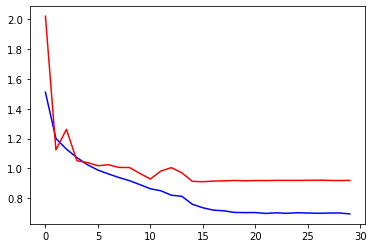

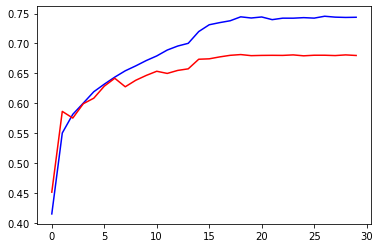

In [25]:
plt.plot(history.history['loss'], color='b')  
plt.plot(history.history['val_loss'], color='r')  
plt.show()
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r') 
plt.show()

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt 

In [28]:
based_model_last_block_layer_number = 126  # value is based on based model selected.

In [26]:
model.load_weights('./model.h5')

In [29]:
    for layer in model.layers[:based_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True

In [30]:
 model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [32]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=test_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.7043
Epoch 00001: saving model to os./model_weights.h5

Epoch 00001: val_loss did not improve from 0.90950
448/448 [==============================] - 376s 840ms/step - loss: 0.8022 - accuracy: 0.7043 - val_loss: 0.9728 - val_accuracy: 0.6561
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.7177
Epoch 00002: saving model to os./model_weights.h5

Epoch 00002: val_loss did not improve from 0.90950
448/448 [==============================] - 415s 926ms/step - loss: 0.7752 - accuracy: 0.7177 - val_loss: 0.9907 - val_accuracy: 0.6530
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.7243
Epoch 00003: saving model to os./model_weights.h5

Epoch 00003: val_loss did not improve from 0.90950
448/448 [==============================] - 357s 798ms/step - loss: 0.7477 - accuracy: 0.7243 - val_loss: 0.9952 - val_accuracy: 0.6652
E

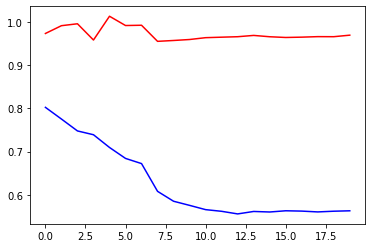

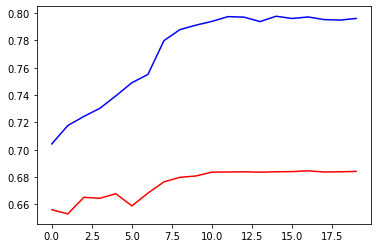

In [33]:
plt.plot(history.history['loss'], color='b')  
plt.plot(history.history['val_loss'], color='r')  
plt.show()
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r') 
plt.show() 